In [1]:
# Importuj TensorFlow i inne biblioteki
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# Pobierz i poznaj zbiór danych - katalogi schema i photo w images to nasze kategorie
import pathlib
data_dir = 'images'
data_dir = pathlib.Path(data_dir)

In [4]:
# Po pobraniu powinieneś mieć teraz dostępną kopię zbioru danych. Łącznie jest 25 obrazów:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

25


In [9]:
photos = list(data_dir.glob('photo/*'))
schemas = list(data_dir.glob('schema/*'))

In [13]:
# Załaduj dane za pomocą narzędzia Keras
batch_size = 32
img_height = 180
img_width = 180

In [14]:
# Dobrą praktyką jest używanie podziału walidacji podczas opracowywania modelu. Użyjmy 80% obrazów do szkolenia, a 20% do walidacji.
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 25 files belonging to 2 classes.
Using 20 files for training.
Found 25 files belonging to 2 classes.
Using 5 files for validation.


In [15]:
# Nazwy klas można znaleźć w atrybucie class_names w tych zestawach danych. Odpowiadają one nazwom katalogów w kolejności alfabetycznej.
class_names = train_ds.class_names
print(class_names)

['photo', 'schema']


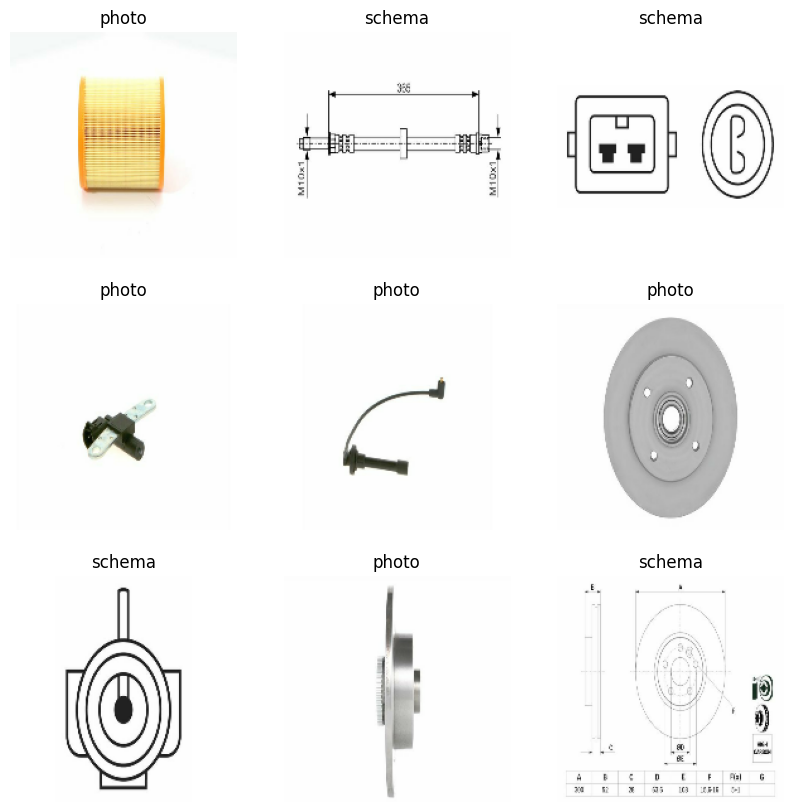

In [16]:
# Wizualizuj dane
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(20, 180, 180, 3)
(20,)


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
# Standaryzuj dane
normalization_layer = layers.Rescaling(1./255)

In [21]:
# Istnieją dwa sposoby wykorzystania tej warstwy. Możesz zastosować go do zestawu danych, wywołując Dataset.map
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [22]:
# Stwórz model
num_classes = len(class_names)

In [23]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
# Skompiluj model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
# Podsumowanie modelu
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [27]:
#Trenuj modelkę
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


1/1 [==============================] - 0s 454ms/step - loss: 0.4712 - accuracy: 1.0000 - val_loss: 0.6763 - val_accuracy: 0.6000
Epoch 2/10
1/1 [==============================] - 0s 496ms/step - loss: 0.3918 - accuracy: 1.0000 - val_loss: 0.6266 - val_accuracy: 0.6000
Epoch 3/10
1/1 [==============================] - 1s 509ms/step - loss: 0.3065 - accuracy: 1.0000 - val_loss: 0.5698 - val_accuracy: 0.6000
Epoch 4/10
1/1 [==============================] - 0s 424ms/step - loss: 0.2205 - accuracy: 1.0000 - val_loss: 0.7659 - val_accuracy: 0.6000
Epoch 5/10
1/1 [==============================] - 1s 509ms/step - loss: 0.1535 - accuracy: 1.0000 - val_loss: 0.6375 - val_accuracy: 0.6000
Epoch 6/10
1/1 [==============================] - 0s 370ms/step - loss: 0.0720 - accuracy: 1.0000 - val_loss: 0.6684 - val_accuracy: 0.6000
Epoch 7/10
1/1 [==============================] - 0s 364ms/step - loss: 0.0488 - accuracy: 1.0000 - val_loss: 0.9828 - val_accuracy: 0.6000
Epoch 8/10
1/1 [===============

In [28]:
# Wizualizuj wyniki treningu
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

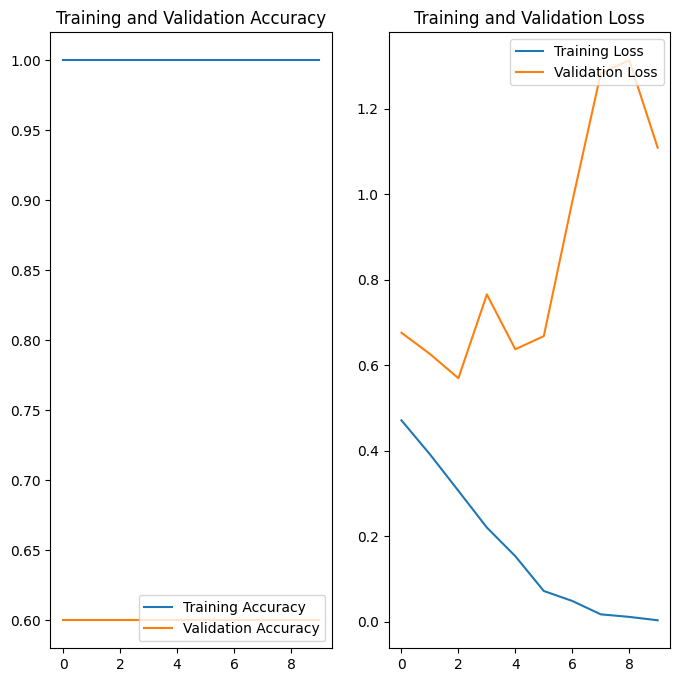

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
# Rozszerzanie danych
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

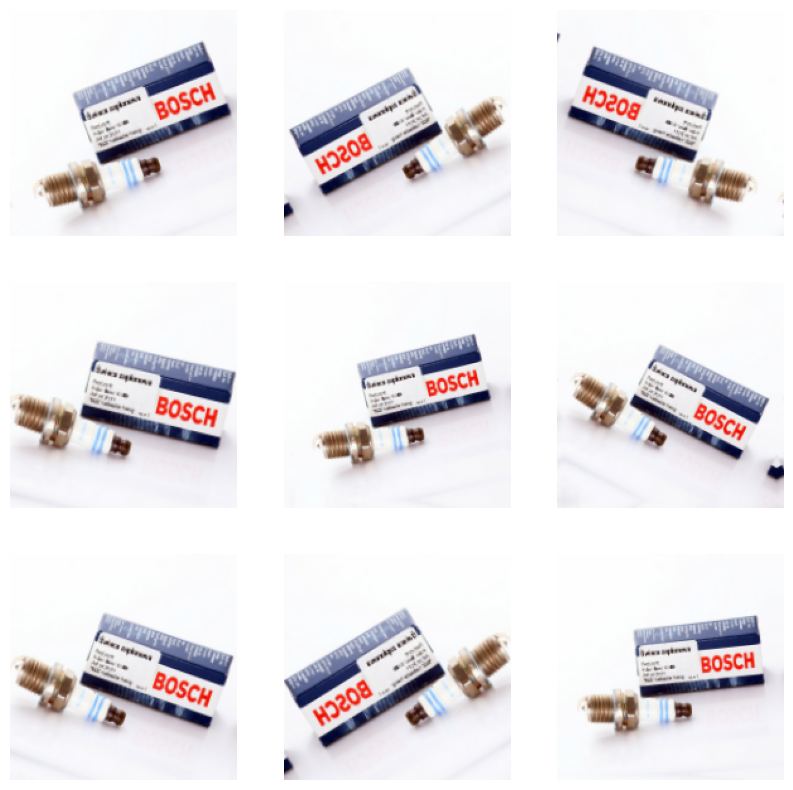

In [31]:
# Zobrazujmy, jak wygląda kilka rozszerzonych przykładów, stosując kilkakrotne rozszerzenie danych do tego samego obrazu:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [32]:
# Spadkowicz
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [33]:
# Skompiluj i trenuj model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

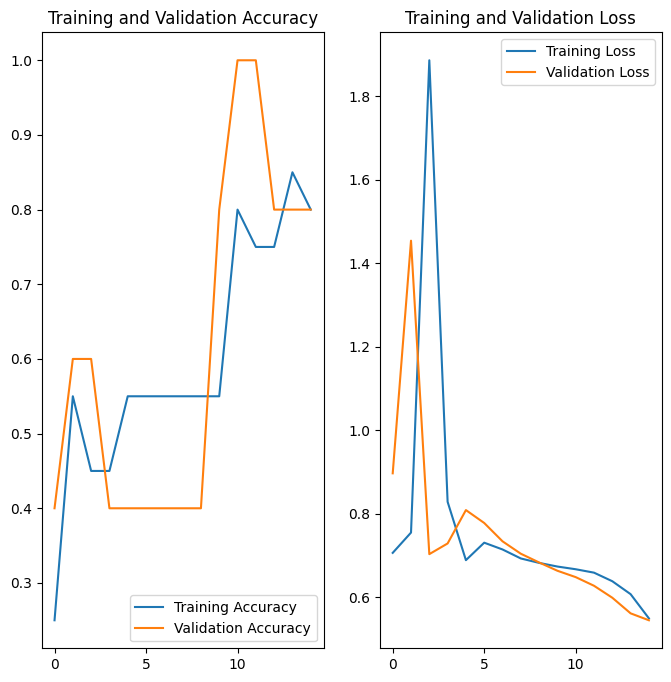

In [34]:
# Wizualizuj wyniki treningu
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
# Przewiduj nowe dane
test_photo_url = "https://v.iparts.pl/000/AKU000023-IPA/dokumenty/akumulator-iparts.jpg"
test_photo_path = tf.keras.utils.get_file('Red_sunflower', origin=test_photo_url)

In [40]:
img = tf.keras.utils.load_img(
    test_photo_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 54ms/step
This image most likely belongs to schema with a 54.32 percent confidence.
